In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect
from datetime import datetime

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine


Engine(sqlite:///Resources/hawaii.sqlite)

In [10]:
inspector = inspect(engine)

In [11]:
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
engine.execute(text('SELECT * FROM station LIMIT 5')).fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date[0]

'2017-08-23'

In [21]:
split_date = datetime.strptime(most_recent_date[0], "%Y-%m-%d")

Text(0, 0.5, 'Inches')

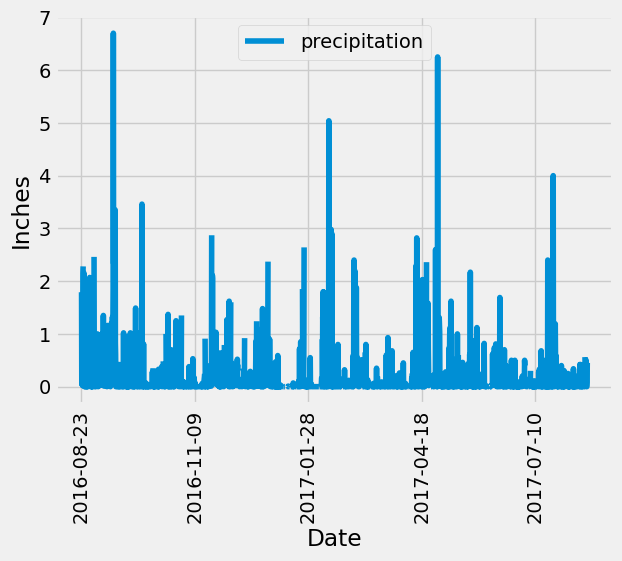

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(split_date.year,split_date.month,split_date.day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores=session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date>=query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp_scores, columns=['precipitation','date'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x = 'date', y = 'precipitation', rot = 90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).group_by(Station.station).count()

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations=session.query(Measurement.station, func.count(Measurement.station)).\
  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
most_active_station=stations[0]['station']
most_active_station

'USC00519281'

In [27]:
temp_result = session.query(*sel).\
    filter(Measurement.station == most_active_station).all()
temp_result

[(54.0, 85.0, 71.66378066378067)]

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date=session.query(Measurement.date).\
            filter(Measurement.station==most_active_station).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-18',)

In [29]:
split_date = datetime.strptime(recent_date[0], "%Y-%m-%d")

In [30]:
query_date = dt.date(split_date.year,split_date.month,split_date.day) - dt.timedelta(days=365)

In [31]:
temperature=session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.date>=query_date).\
    filter(Measurement.station == most_active_station).all()

Text(0, 0.5, 'Frequency')

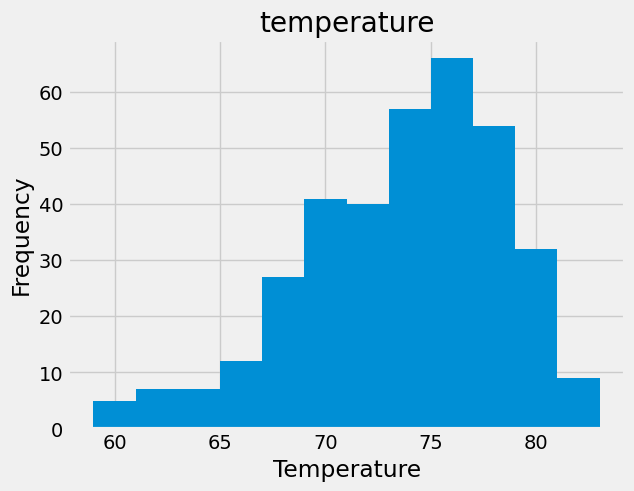

In [32]:
#plot histogram by loading query results into a DataFrame
temp_df = pd.DataFrame(temperature, columns=['temperature','date'])
temp_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close Session

In [33]:
# Close Session
session.close()